In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [2]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 980, 1470])


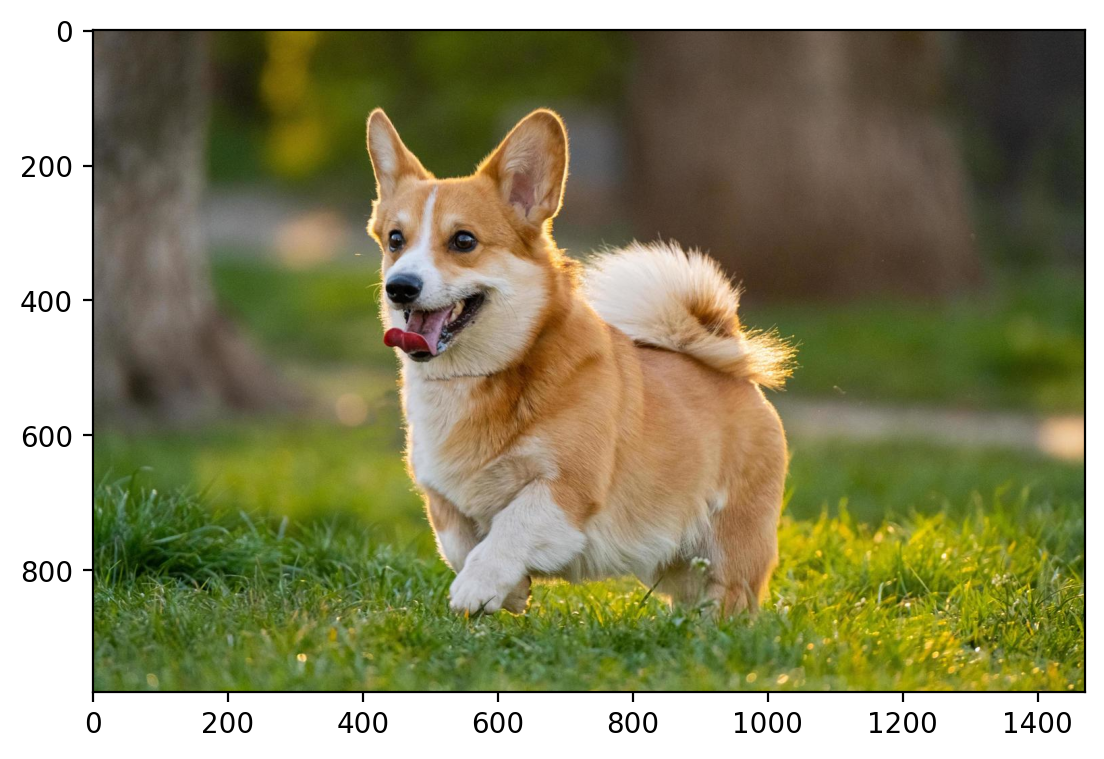

In [3]:
plt.imshow(rearrange(img, 'b h w -> h w b').numpy())

In [4]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [5]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 980, 1470])

In [6]:
cropped_image = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 300, 300)
cropped_image.to(device)
cropped_image.shape

torch.Size([3, 300, 300])

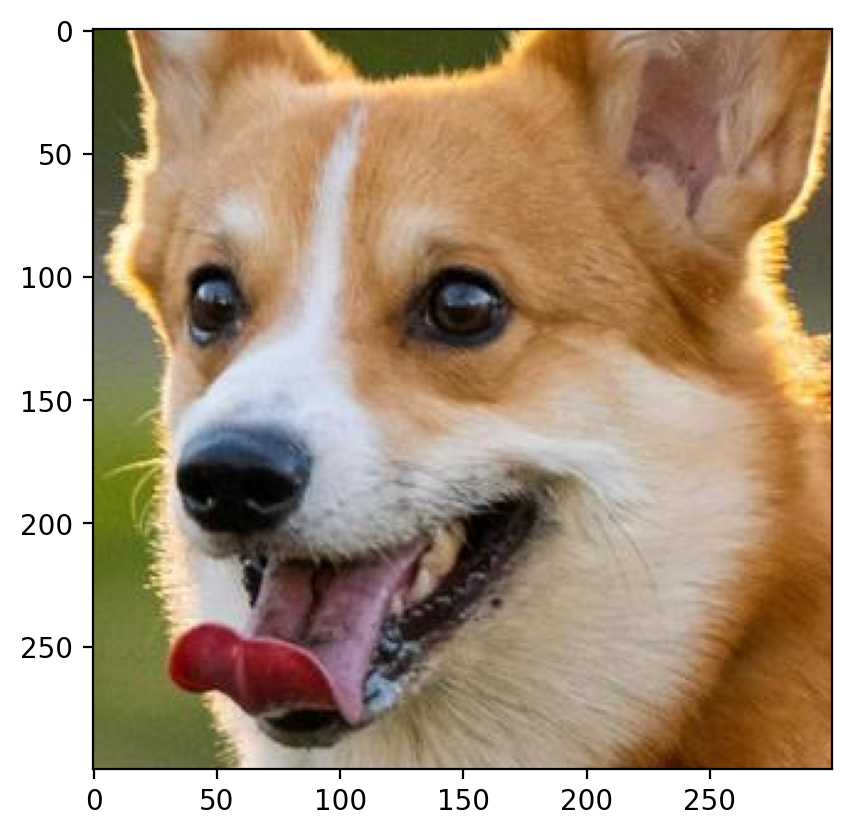

In [7]:
plt.imshow(rearrange(cropped_image, 'c h w -> h w c').cpu().numpy())

In [8]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [9]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)) #converts to 1D array of 3*h*w 3 is channels
img_scaled = img_scaled.reshape(img.shape)

img_scaled = torch.tensor(img_scaled)
img_scaled.shape

torch.Size([3, 980, 1470])

In [10]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 200, 400, 300, 300)
crop.to(device)
crop.shape

torch.Size([3, 300, 300])

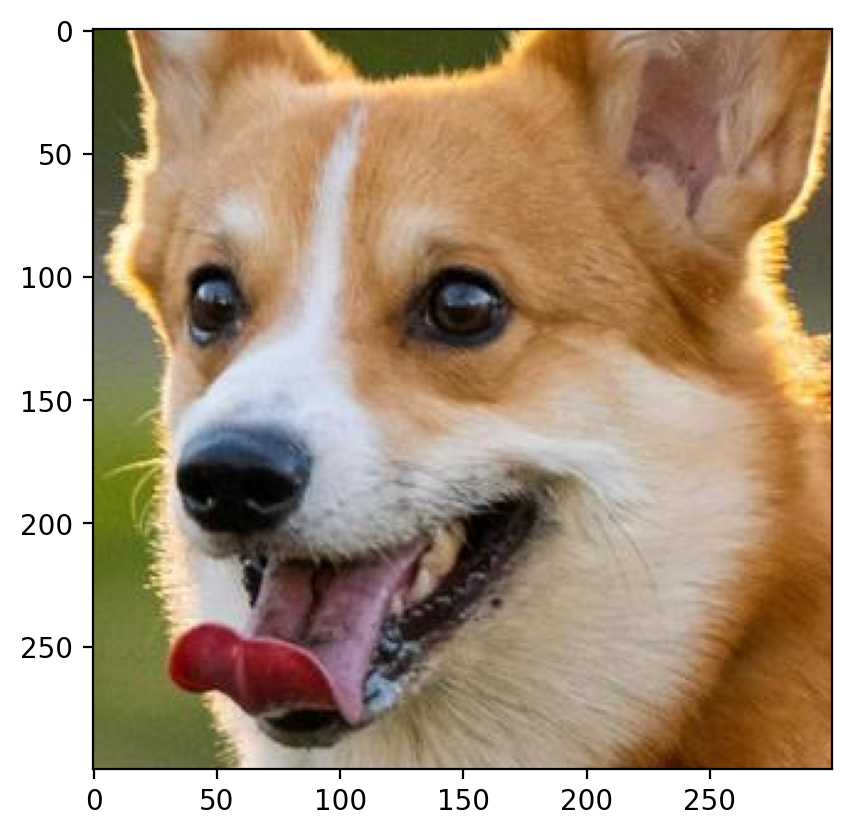

In [11]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [12]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    X = torch.stack([h_coords, w_coords], dim=1).to(torch.float32)

    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').to(torch.float32)
    return X, Y

In [14]:
dog_X, dog_Y = create_coordinate_map(crop)
dog_X.shape, dog_Y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [15]:
dog_Y = torch.tensor(dog_Y).to(device) #delete for gpu

In [24]:
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(dog_X.cpu())  #road_X will work for GPU, but sklearn is for cpu
dog_X_scaled = scaler_X.transform(dog_X.cpu())
dog_X_scaled = torch.tensor(dog_X_scaled).to(device)

# Set to dtype float32
dog_X_scaled = dog_X_scaled.to(torch.float32)

In [25]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)
net = LinearModel(2, 3)
net.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [26]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [27]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ##Now plotting for original image

    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [28]:
def poly_features(X, degree):
    """
    X: torch.Tensor of shape (num_samples, 2)
    degree: int

    return: torch.Tensor of shape (num_samples, degree * (degree + 1) / 2)
    """
    X1 = X[:, 0]  #1st column or feature
    X2 = X[:, 1]  #2nd column or feature

    X1 = X1.unsqueeze(1)  #making it in shape of (90000,1)
    X2 = X2.unsqueeze(1)
    X = torch.cat([X1, X2], dim=1)  #Concatenating along column

    poly = preprocessing.PolynomialFeatures(degree=degree)
    X = poly.fit_transform(X.cpu())

    return torch.tensor(X, dtype=torch.float32).to(device)

In [29]:
dog_X_scaled_poly = poly_features(dog_X_scaled, 50)
dog_X_scaled_poly.dtype, dog_X_scaled_poly.shape, dog_Y.shape, dog_Y.dtype

(torch.float32,
 torch.Size([90000, 1326]),
 torch.Size([90000, 3]),
 torch.float32)

In [32]:
net = LinearModel(dog_X_scaled_poly.shape[1], 3)
net.to(device)

train(net, 0.005, dog_X_scaled_poly, dog_Y, 1000)

Epoch 0 loss: 0.308550
Epoch 100 loss: 0.033707
Epoch 200 loss: 0.029586
Epoch 300 loss: 0.028466
Epoch 400 loss: 0.027856
Epoch 500 loss: 0.027424
Epoch 600 loss: 0.027138
Epoch 700 loss: 0.026913
Epoch 800 loss: 0.026725
Epoch 900 loss: 0.026560


0.02641376107931137

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


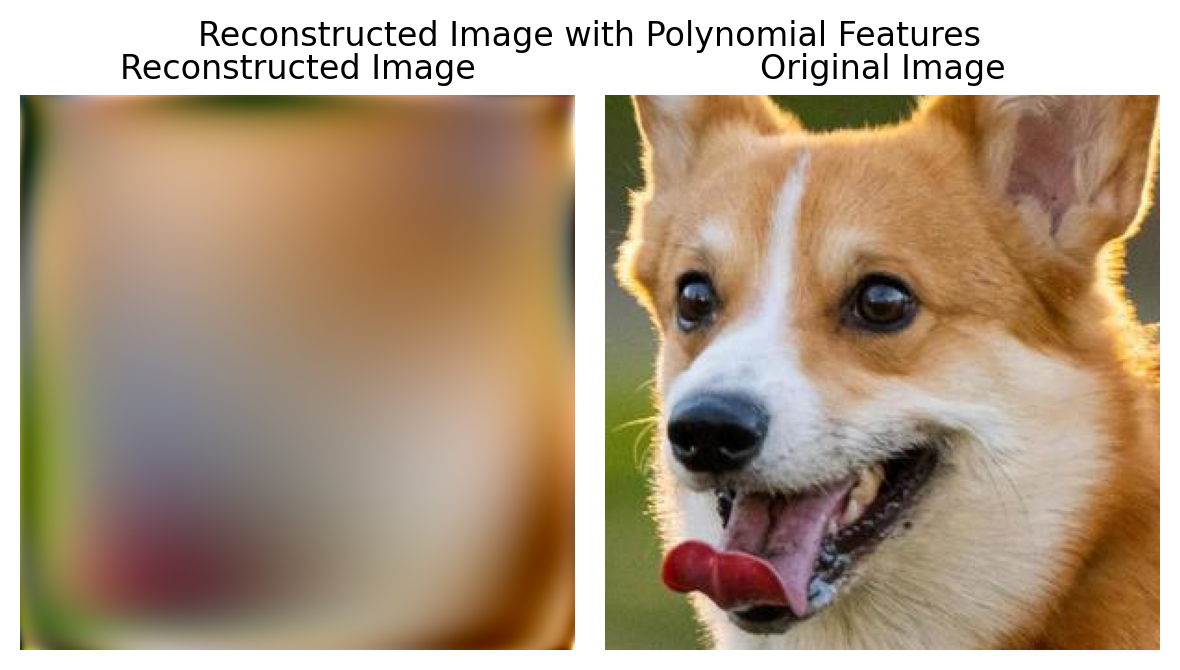

In [33]:
plot_reconstructed_and_original_image(crop, net, dog_X_scaled_poly, title="Reconstructed Image with Polynomial Features")

In [34]:
def create_rff_features(X, num_features, sigma, device, batch_size=5000):
    n_samples, n_features = X.shape

    # Generate random weights and bias for RFF (weights can be large, so precompute and store on GPU)
    W = torch.randn(n_features, num_features, device=device) / sigma  # Random Gaussian weights
    b = 2 * torch.pi * torch.rand(num_features, device=device)  # Random bias

    Z_list = []  # Store the chunks of transformed data

    # Process the input in smaller batches to reduce memory usage
    for i in range(0, n_samples, batch_size):
        X_batch = X[i:i + batch_size]  # Slice the batch from the input tensor
        Z_batch = torch.matmul(X_batch, W) + b  # Linear transformation
        Z_batch = torch.cos(Z_batch) * (2.0 / torch.sqrt(torch.tensor(num_features, dtype=torch.float32, device=device)))  # Apply cosine and normalize
        Z_list.append(Z_batch)

    # Concatenate all the processed batches to form the final tensor
    Z = torch.cat(Z_list, dim=0)

    return Z

In [35]:
X_rff = create_rff_features(dog_X_scaled, 8000, 0.008, device)

In [37]:
net = LinearModel(X_rff.shape[1], 3) 
net.to(device)

train(net, 0.005, X_rff, dog_Y, 1000)

Epoch 0 loss: 0.311086
Epoch 100 loss: 0.044784
Epoch 200 loss: 0.021716
Epoch 300 loss: 0.018986
Epoch 400 loss: 0.017654
Epoch 500 loss: 0.016774
Epoch 600 loss: 0.016147
Epoch 700 loss: 0.015677
Epoch 800 loss: 0.015310
Epoch 900 loss: 0.015013


0.014767110347747803

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


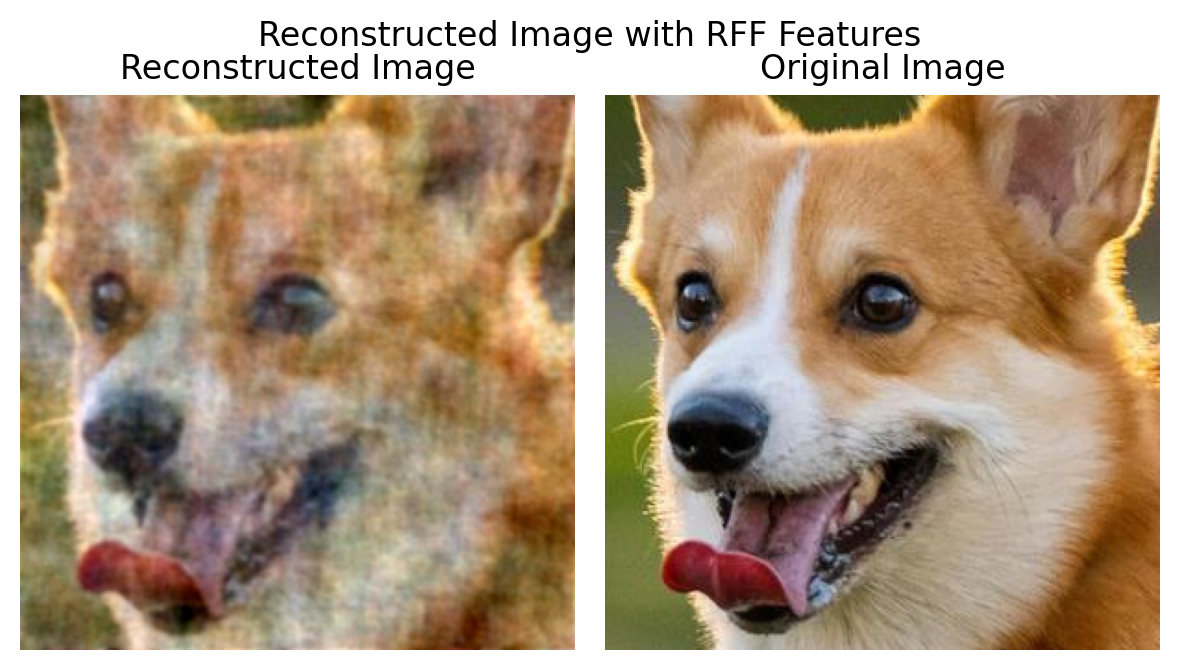

In [38]:
plot_reconstructed_and_original_image(crop, net, X_rff, title="Reconstructed Image with RFF Features")

In [47]:
num_channels, height, width = crop.shape
net.eval()
with torch.no_grad():
    outputs = net(X_rff)
    outputs = outputs.reshape(height, width, num_channels)
fig = plt.figure(figsize=(6, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
print("Reconstructed pixels:\n",outputs), print("\n\nOriginal pixels\n",crop)

Reconstructed pixels:
 tensor([[[0.2536, 0.1833, 0.1447],
         [0.2489, 0.1858, 0.1022],
         [0.2719, 0.2115, 0.1052],
         ...,
         [0.5395, 0.3899, 0.2809],
         [0.5588, 0.4132, 0.3079],
         [0.5863, 0.4309, 0.3403]],

        [[0.2426, 0.2105, 0.1131],
         [0.2165, 0.2015, 0.0616],
         [0.2308, 0.2207, 0.0644],
         ...,
         [0.5571, 0.3926, 0.2510],
         [0.5787, 0.4187, 0.2833],
         [0.5927, 0.4224, 0.3070]],

        [[0.2789, 0.2574, 0.1359],
         [0.2347, 0.2362, 0.0739],
         [0.2363, 0.2434, 0.0673],
         ...,
         [0.5983, 0.4220, 0.2751],
         [0.6331, 0.4589, 0.3182],
         [0.6516, 0.4611, 0.3422]],

        ...,

        [[0.4648, 0.4448, 0.2982],
         [0.4752, 0.4451, 0.2864],
         [0.5087, 0.4768, 0.3135],
         ...,
         [0.7225, 0.5216, 0.3581],
         [0.7267, 0.5176, 0.3655],
         [0.7649, 0.5642, 0.4351]],

        [[0.4680, 0.4483, 0.3013],
         [0.4830, 0.4484

(None, None)

<Figure size 600x400 with 0 Axes>

In [48]:
crop_rearranged = crop.permute(1, 2, 0).to(device)
print(crop_rearranged.shape)
print(outputs.shape)

torch.Size([300, 300, 3])
torch.Size([300, 300, 3])


In [49]:
def compute_rmse(tensor1, tensor2):
    # Ensure both tensors are on the same device (GPU)
    assert tensor1.shape == tensor2.shape, "Tensors must have the same shape"

    mse = torch.mean((tensor1 - tensor2) ** 2)
    rmse = torch.sqrt(mse)
    return rmse.item()

def compute_psnr(tensor1, tensor2, max_pixel_value=1.0):
    mse = torch.mean((tensor1 - tensor2) ** 2)
    psnr = 10 * torch.log10(max_pixel_value ** 2 / mse)
    return psnr.item()

In [50]:
rmse = compute_rmse(crop_rearranged, outputs)
psnr = compute_psnr(crop_rearranged, outputs)

print(f"RMSE: {rmse}")
print(f"PSNR: {psnr}")

RMSE: 0.12151060182469323
PSNR: 18.307716562614967
